# Description

This code loads in each Climate Model Intercomparison Project 5 (CMIP5) historical+projected global mean temperature data (here, labeled 'TPMN'), determines the central year when each model's 31-year centered-running-mean  timeseries of GMST exceeds 1.07C (relative to the 1850&mdash;1899 IPCC pre-industrial reference period, see [hadcrut_GMST.ipynb](./hadcrut_GMST.ipynb)), and saves out a table with the results into a .csv file, [CMIP5_crossing_year_1.07.csv](./data/analysis/CMIP5_crossing_year_1.07.csv).

# Setup

In [1]:
# import the packages we need to run this code
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import utilities as util

#### Define attributable temperature anomaly since 1850&mdash;1899 to match observations

In [24]:
# define the attributable warming from the IPCC
deltaC=np.round(1.07,2)

# Load CMIP5 GMST data

CMIP5 data originally downloaded by Karsten Haustein from the [Centre for Environmental Analysis (CEDA)](https://help.ceda.ac.uk/article/4465-cmip5-data) in November 2018. GMST anomalies were calculated relative to the 1850&mdash;1899 IPCC pre-industrial reference period on 23 August 2021.

In [2]:
# define the variable name of GMST in the files
gmst_metric='TPMN'

# Define and get the model file location and names
fLpath='./data/cmip5/30-year_GMST_anom1850-1899/'
fl=[f for f in os.listdir(fLpath)]
models=[s[:-74] for s in fl]
nmodel=len(models)
# print the list of climate models in CMIP5
print(np.ravel(models))

['CMCC-CMS' 'CSIRO-Mk3-6-0' 'MPI-ESM-LR' 'MRI-CGCM3' 'MIROC-ESM'
 'bcc-csm1-1-m' 'CMIP5_histori' 'ACCESS1-0' 'bcc-csm1-1' 'inmcm4'
 'NorESM1-M' 'IPSL-CM5A-MR' 'MIROC-ESM-CHEM' 'IPSL-CM5B-LR' 'MIROC5'
 'CMCC-CESM' 'MPI-ESM-MR' 'GFDL-CM3' 'CCSM4' 'CMCC-CM' 'CESM1-BGC'
 'CESM1-CAM5' 'EC-EARTH' 'CanESM2' 'ACCESS1-3']


### Load Data/Plot for reference

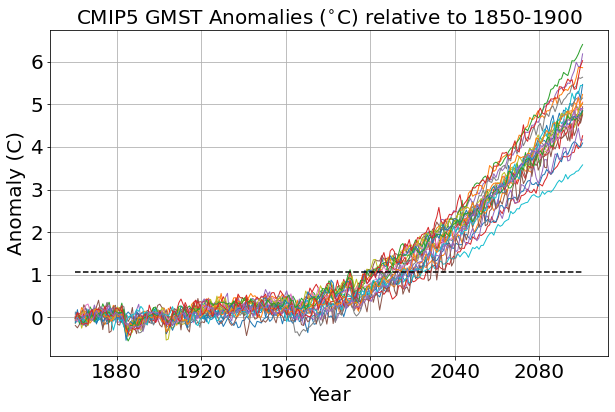

In [32]:
# set up the plot
plt.figure(figsize=(10,6))

# loop over each model to load in the data, organize it, and plot
for i,f in enumerate(fl):
    
    # get this model's path and name
    pathin=fLpath+f
    mname=models[i]
    
    # load this model's data
    dat=xr.open_dataset(pathin)
    
    # remove missing data, set missing equal to NaN
    dat = dat.where(dat[gmst_metric] > -273.15, other=np.nan)
    
    # use datetime64 to convert/define time information
    dat['time']=util.get_dt64(dat)
    
    # plot the timeseries for this model
    plt.plot(dat.time,dat[gmst_metric].values.flatten(),lw=1,label=mname)
    
    # store the data
    
    # if this is the first iteration, initialize
    if i==0:
        
        # initialize time and data storage
        ntime=len(dat['time'])
        gmst_all=np.zeros((nmodel,ntime),dtype='float64')
        
        # find the timegrid for all models
        timegrid=dat.time
        
        # find the model years
        myears=[int(i) for i in timegrid.groupby('time.year').groups.keys()]
        
    # store the GMST for this model
    gmst_all[i,:]=dat[gmst_metric].values.flatten()
    
# overplot the attributable warming as a horizontal line
plt.hlines(deltaC,dat.time[0].values,dat.time[-1].values,color='k',ls='--')
    
# plot all of the results together and organize plot labels
plt.title('CMIP5 GMST Anomalies ($^{\circ}$C) relative to 1850-1900',fontsize=20)
plt.ylabel('Anomaly (C)',fontsize=20)
plt.xlabel('Year',fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.axis('tight')
plt.grid()
# plt.legend()
plt.show()

# Find year when each model exceeds attributable warming

!!!WE APPLY A SMOOTHER TO FILTER OUT INTERANNUAL VARIABILITY SO WE KNOW THAT THE CHANGES ARE OCCURING FROM CLIMATE VARIATIONS

In [33]:
# copy the GMST dataset for each model, for use in filtering
gmst_anom=gmst_all.copy()
# create an array to store the results in
cross_yr=np.zeros((nmodel,),dtype='int')

# loop over each of the models
for i in range(nmodel):
    
    # fill any missing data points with an average in between
    if gmst_anom[i,:].dropna()...
    gmst_all[i,:]=util.fill_nan(gmst_all[i,:])
    # PRINT OUT WHERE THIS WOULD BE HAPPENING!
    gmst_anom[i,:]=gmst_all[i,:]
    
    # apply a 31-year centered boxcar filter
    gmst_31year_mean=np.convolve(gmst_anom[i,:], np.ones(31)/31, mode='valid')
    
    # find the year where the 31-year smoothed data crosses the attributable warming threshold
    cross_i=np.argmin(np.abs(gmst_31year_mean-deltaC))+int((np.shape(gmst_anom)[1]-np.shape(gmst_31year_mean)[0])/2)+1
    
    # store the result
    cross_yr[i,]=timegrid[cross_i]['time.year']

AttributeError: module 'utilities' has no attribute 'fill_nan'

In [ ]:
alphai=np.argsort(modelnames)
print(np.asarray(modelnames)[alphai])
print(cross_yr[alphai])
print(cross_yr10[alphai])

In [ ]:
for i in range(nmodel):
    print(np.asarray(modelnames)[alphai][i], cross_yr[alphai][i])

In [ ]:
for i in range(nmodel):
    print(np.asarray(modelnames)[alphai][i], cross_yr[alphai][i]-15,'-',cross_yr[alphai][i]+15)

# SAVE OUT

In [ ]:
cross_dropavg=cross_yr.copy()
#drop the historical average from the array
cross_dropavg=np.delete(cross_dropavg,6)
models_dropavg=modelnames.copy()
del models_dropavg[6]

In [ ]:
import pandas as pd 
cross_df=pd.DataFrame(cross_dropavg,index=models_dropavg,columns=['Crossing-Year-1.13C'])
cross_df

In [ ]:
cross_df.to_csv('/home/dgilford/attribution/paper_data_out/CMIP5_crossing_year_1.13C.csv')

# PLOT

In [11]:
bincheck=np.arange(1990-2.5,2040+1-2.5,5)
bincheck

array([1987.5, 1992.5, 1997.5, 2002.5, 2007.5, 2012.5, 2017.5, 2022.5,
       2027.5, 2032.5, 2037.5])

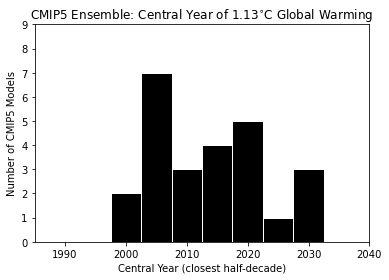

In [12]:
plt.figure()
plt.hist(cross_yr,bins=bincheck,color='k',edgecolor='white')
plt.title('CMIP5 Ensemble: Central Year of $1.13^{\circ}$C Global Warming')
plt.xlabel('Central Year (closest half-decade)')
plt.ylabel('Number of CMIP5 Models')
plt.yticks(np.arange(10))
plt.show()